In [1]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit

from jupyterthemes import jtplot
jtplot.style(theme='onedork')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,6)

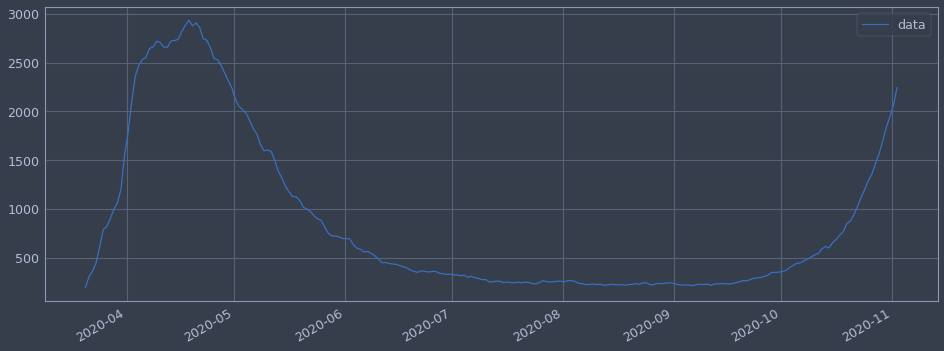

In [2]:
# data-source: https://datawrapper.dwcdn.net/WvhXR/

df_raw = pd.read_csv('data-WvhXR.csv', index_col=0, names=['data'], header = 0)
df_raw.index = pd.to_datetime(df_raw.index, utc=True)
df_raw.plot()

In [3]:
find_min_start = '2020-05'
find_min_end = '2020-10'

argmin = df_raw[(df_raw.index > find_min_start) & 
                (df_raw.index < find_min_end) & 
                (df_raw.data == df_raw.data[find_min_start:find_min_end].min())].index[0]

df_fit = df_raw[argmin:] # sadly this doesn't work later on
df_fit = df_raw[find_min_end:] # so I have to do this

In [4]:
def gaussian(x, sat, td, velo, offset):
    x = np.float64(x) / 1e18
    sat *= 1e4
    offset *= 1e3
    velo /=1e2

    return (sat * np.exp(-(x-td)**2/(2*velo**2))) + offset

<ipython-input-5-1b92dc1ec65a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit['fit'] = gaussian(df_fit.index, *list(popt))
<ipython-input-5-1b92dc1ec65a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit['res'] = df_fit.data - df_fit.fit


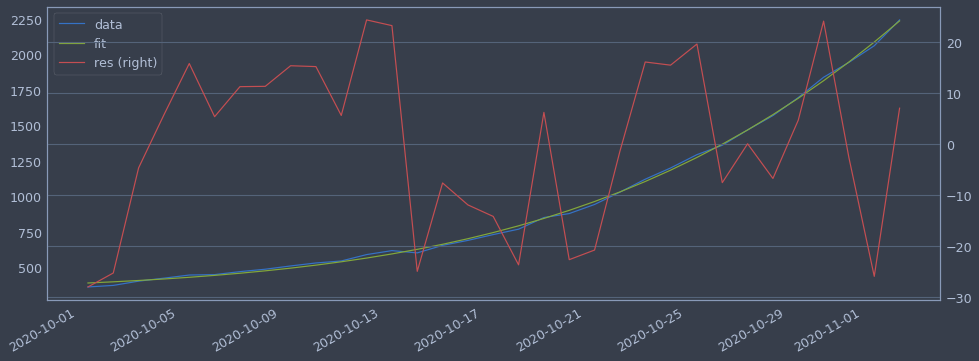

In [5]:
sat = 1
td = 1.61
velo = .3
offset = .1

popt, pcov = curve_fit(f = gaussian, 
                       xdata = df_fit.index, 
                       ydata = df_fit.data,
                    p0 = (sat, td, velo, offset),
                       maxfev=1000
                      )

df_fit['fit'] = gaussian(df_fit.index, *list(popt))
df_fit['res'] = df_fit.data - df_fit.fit

df_fit.plot(secondary_y="res")

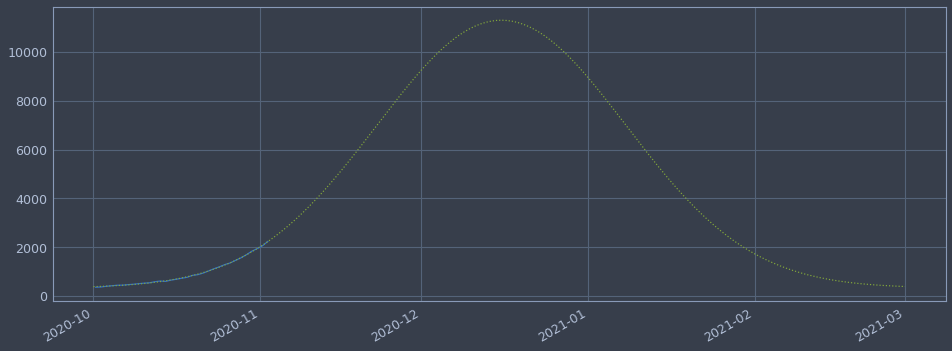

In [6]:
ix_extrapol = pd.date_range("2020-10", "2021-3")

df_fit.data.plot()
pd.Series(gaussian(ix_extrapol, *list(popt)), index=ix_extrapol).plot(style=':')

In [7]:
maxdate = datetime.datetime.fromtimestamp(popt[1] * 1e9)
maxdate.strftime("%Y-%B-%d %H:%M")

'2020-December-15 23:00'

In [8]:
popt[0] * 1e4

10968.516134627585

In [9]:
sigma = datetime.timedelta(seconds=(popt[2] / 1e2) * 1e9)
sigma

datetime.timedelta(days=23, seconds=17885, microseconds=442214)

In [10]:
maxdate - sigma

datetime.datetime(2020, 11, 22, 18, 2, 13, 975943)

In [11]:
ix_next = df_fit.index[-1] + datetime.timedelta(1)
gaussian(time.mktime(ix_next.timetuple())*1e9, *list(popt))

2386.9684934411257